# Simple Metallic Chain

This notebook demonstrates a quantum transport calculation using the JunPy package. The goal is to compute the density of states and transmission values for a two-probe device. We manually construct the tight-binding Hamiltonian by setting the onsite energies and hopping parameters.

## Import Necessary Libraries

We use the built-in module `junpy.factory.stack` to create a simple two-probe device and its tight-binding Hamiltonian.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import junpy as jp
from junpy.factory import stack
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'font.size': 12}

## Build Device

For demonstration, we assume there are 3 sites in the central region and 1 site in each of the left and right electrode unit cells. The spin-polarized onsite energies for each site are set to `np.array([[-0.5, 0], [0, 0.5]])`, where `-0.5` corresponds to spin-up and `0.5` corresponds to spin-down. The hopping energies are set to `-1`. The spin polarization angles are aligned along the $z$ direction, with values set to `0` radians.

In [2]:
# on-site energy
eA = np.array([[-0.5, 0], [0, 0.5]])
eB = np.array([[-0.5, 0], [0, 0.5]])
eC = np.array([[-0.5, 0], [0, 0.5]])

# hopping energy
t = np.array([[-1, 0], [0, -1]])

# spin polarization angle in unit of radian
sA, sB, sC,  = 0, 0, 0

We first create an empty builder using `stack.TwoProbeDeviceBuilder()` to construct the device:

In [3]:
builder = stack.TwoProbeDeviceBuilder()

The following statements construct the Hamiltonian parameters for the two-probe device. Here, `builder.L`, `builder.C`, and `builder.R` represent the left, central, and right regions, respectively. The left and right regions are semi-infinite electrodes. To construct the Fermi function, we need to set the reservoir chemical potential and temperature. In this example, the reservoir chemical potentials are set to `0`, and the temperatures are set to `100` K. For each region, the `add(energy, hopping, nsites, spin, bias)` function is used to create a layer containing the Hamiltonian parameters. Here, `energy` refers to the onsite energy, `hopping` specifies the hopping energy, `nsites` is the number of sites in the layer, `spin` is the spin polarization angle in radians, and `bias` represents the energy shift of the onsite energy.

In [4]:
# left electrode
builder.L.set(chemicalPotential=0, temperature=100)
builder.L.add(eA, t, nsites=1, spin=sA, bias=0)

# central region
builder.C.add(eA, t, nsites=1, spin=sA, bias=0)
builder.C.add(eB, t, nsites=3, spin=sB, bias=0)
builder.C.add(eC, t, nsites=1, spin=sC, bias=0)

# right electrode
builder.R.set(chemicalPotential=0, temperature=100)
builder.R.add(eC, t, nsites=1, spin=sC, bias=0)

The coupling energies between the layers also need to be specified. We assume that all coupling energies are set to `t`.

In [5]:
# define coupling between layers
builder.set_layer_coupling(all=t)

The default transport direction is the $z$ direction. To construct a 2D or 3D device, we can set the translation symmetry in the $x$ and $y$ directions. In this example, we construct a simple 1D two-probe device, so the translation symmetry is disabled.

In [6]:
# define translation symmetry
builder.set_translationSymmetry(x=False, y=False)

Once the construction is finished, use `create_device` to build the device.

In [7]:
# create device
device = builder.create_device()

## Calculate Density of States

In [8]:
calcr_dos = jp.DensityOfStates(
    device=device,
    energies=np.linspace(-3, 3, 61),
    kpoints=jp.SymmetryKspaceSampling((1,1,1)),
    etaSigma=0.01)
jp.run(calcr_dos, savefile=False)

JunPy version---------------------------: 0.15.0.post29+ga5b3260
Parallelization information
    BLAS Vendor-----------------------------: MKL
    Total number of MPI processes-----------: 1
    OMP_NUM_THREADS-------------------------: 1
    MKL_NUM_THREADS-------------------------: unset
    OPENBLAS_NUM_THREADS--------------------: unset
Calculating density of states... (2024-08-14 20:01:57)
    Device information
        bias (mu2-mu1)--------------------------: 0
        central.numberOfSites-------------------: 5
        central.spinType------------------------: SpinType.GeneralSpin
        lead1.numberOfSites---------------------: 1
        lead1.spinType--------------------------: SpinType.GeneralSpin
        lead1.direction-------------------------: -3
        lead1.temperature-----------------------: 100
        lead1.chemicalPotential-----------------: 0
        lead2.numberOfSites---------------------: 1
        lead2.spinType--------------------------: SpinType.GeneralSpin

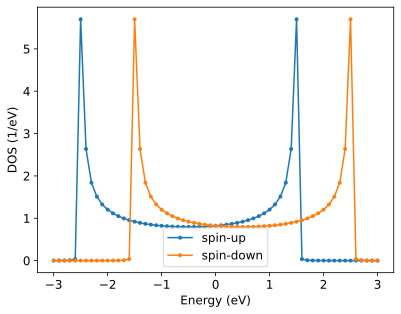

In [9]:
# shape: (#kpoints, #energies, #spin)
dos = calcr_dos.densityOfStates(spin='diag')

plt.plot(calcr_dos.energies, dos[0,:,0], '.-', label='spin-up')
plt.plot(calcr_dos.energies, dos[0,:,1], '.-', label='spin-down')
plt.xlabel('Energy (eV)')
plt.ylabel('DOS (1/eV)')
plt.legend()
plt.show()

## Calculate Transmission

In [10]:
calcr_trans = jp.Transmission(
    device=device,
    energies=np.linspace(-3, 3, 61),
    kpoints=jp.SymmetryKspaceSampling((1,1,1)),
    etaSigma=1e-4,
)
jp.run(calcr_trans, savefile=False)

JunPy version---------------------------: 0.15.0.post29+ga5b3260
Parallelization information
    BLAS Vendor-----------------------------: MKL
    Total number of MPI processes-----------: 1
    OMP_NUM_THREADS-------------------------: 1
    MKL_NUM_THREADS-------------------------: unset
    OPENBLAS_NUM_THREADS--------------------: unset
Calculating transmission... (2024-08-14 20:02:20)
    Device information
        bias (mu2-mu1)--------------------------: 0
        central.numberOfSites-------------------: 5
        central.spinType------------------------: SpinType.GeneralSpin
        lead1.numberOfSites---------------------: 1
        lead1.spinType--------------------------: SpinType.GeneralSpin
        lead1.direction-------------------------: -3
        lead1.temperature-----------------------: 100
        lead1.chemicalPotential-----------------: 0
        lead2.numberOfSites---------------------: 1
        lead2.spinType--------------------------: SpinType.GeneralSpin
    

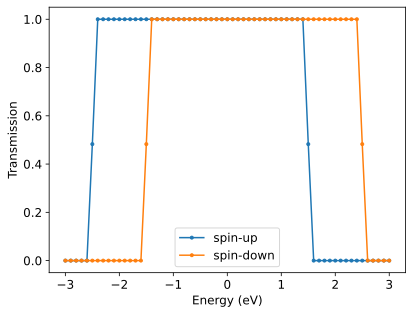

In [11]:
# shape: (#kpoints, #energies, #spin)
trans = calcr_trans.transmission(spin='diag')

plt.plot(calcr_trans.energies, trans[0,:,0], '.-', label='spin-up')
plt.plot(calcr_trans.energies, trans[0,:,1], '.-', label='spin-down')
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission')
plt.legend()
plt.show()